In [1]:
# 1

########## 31 July 2023 ##########
####### 7 September 2023 #########
###### 13 September 2023 #########
###### 19 September 2023 #########
# In this notebook, I am making a comparison between the
# co-add spectrum and its constituents for PID 16196,
# which observed the AGN Mrk 817 with
# COS G130M and G160M, plus with STIS G140L, G230L, G430L, and G750L.
#
# It also observed the standard star WD0308-565 with COS G130M and G160M.
#
# There appear to be 1,383 total base-level constituent spectra,
# with 501 co-added spectra at various levels in the /products/ directory.
#
# I will determine how many of the base-level files go into
# each of these co-added spectra later as part of this notebook.
#
# A comparison will be how the co-added constituents compare
# to the final spectra, and how the base-level files build up
# the constituents.
#

In [2]:
# 2

# Load the relevant packages:

import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.io import fits
from scipy import signal
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.stats import chi2_contingency
from sklearn import preprocessing
import pandas as pd
import os

from matplotlib import rc
rc('text', usetex=True)


In [3]:
# 3

# Plot the co-add spectra.
#
# Set the path to the co-add spectrum's directory
# as well as to the files themselves.

#coadd_path = '/grp/hst/cos2/hsla/archive_2023-07-24/16196/products/'
#coadd_path = '/grp/hst/cos2/hsla/archive_2023_Aug_07/16196/products/'
#coadd_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-08-28/16196/products/'
coadd_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-09-14/16196/products/'

# Note that, since there are a ton of co-added spectra
# (either Visit- or Program-level)
# I'm not going to plot everything here.
#
# Let's just do Program-level for now (all gratings):

Mrk817_coadd_file = 'hst_16196_cos-stis_mrk-817_g130m-g160m-sg230l-g430l-g750l_lede_cspec.fits'

# Here now are all the per-grating co-add constituents:

Mrk817_COS_G130M_const_file = 'hst_16196_cos_mrk-817_g130m_lede_cspec.fits'
Mrk817_COS_G160M_const_file = 'hst_16196_cos_mrk-817_g160m_lede_cspec.fits'
Mrk817_STIS_G140L_const_file = 'hst_16196_stis_mrk-817_sg140l_oede_cspec.fits'
Mrk817_STIS_G230L_const_file = 'hst_16196_stis_mrk-817_sg230l_oede_cspec.fits'
Mrk817_STIS_G430L_const_file = 'hst_16196_stis_mrk-817_g430l_oede_cspec.fits'
Mrk817_STIS_G750L_const_file = 'hst_16196_stis_mrk-817_g750l_oede_cspec.fits'


These are the constituent files for Mrk 817:  ['lede02vbq_x1d.fits' 'lede02vdq_x1d.fits' 'lede02vfq_x1d.fits'
 'lede02vhq_x1d.fits' 'lede03g0q_x1d.fits' 'lede03g2q_x1d.fits'
 'lede03g4q_x1d.fits' 'lede03g6q_x1d.fits' 'lede04maq_x1d.fits'
 'lede04mcq_x1d.fits' 'lede04meq_x1d.fits' 'lede04mgq_x1d.fits'
 'lede05qcq_x1d.fits' 'lede05qeq_x1d.fits' 'lede05qgq_x1d.fits'
 'lede05qiq_x1d.fits' 'lede06yyq_x1d.fits' 'lede06z0q_x1d.fits'
 'lede06z2q_x1d.fits' 'lede06z4q_x1d.fits' 'lede07jyq_x1d.fits'
 'lede07k0q_x1d.fits' 'lede07k2q_x1d.fits' 'lede07k4q_x1d.fits'
 'lede08f3q_x1d.fits' 'lede08f5q_x1d.fits' 'lede08f7q_x1d.fits'
 'lede08fcq_x1d.fits' 'lede09a1q_x1d.fits' 'lede09a3q_x1d.fits'
 'lede09a5q_x1d.fits' 'lede09a7q_x1d.fits' 'lede0cvpq_x1d.fits'
 'lede0cvrq_x1d.fits' 'lede0cvtq_x1d.fits' 'lede0cvvq_x1d.fits'
 'lede0df6q_x1d.fits' 'lede0df8q_x1d.fits' 'lede0dfaq_x1d.fits'
 'lede0dfcq_x1d.fits' 'lede10iyq_x1d.fits' 'lede10j0q_x1d.fits'
 'lede10j2q_x1d.fits' 'lede10j4q_x1d.fits' 'lede11a4q_x1d.

(-2e-14, 3.5e-13)

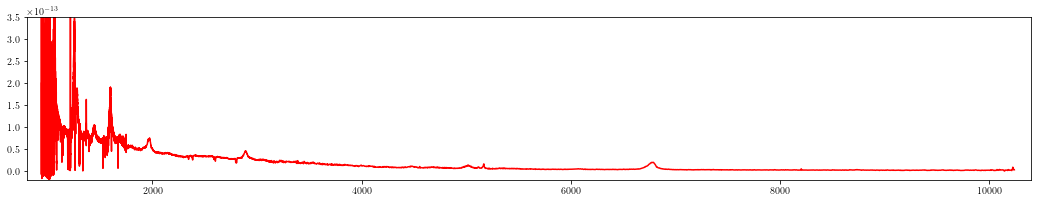

In [4]:
# 4

# First I'll plot the final co-add for Mrk 817.

plt.figure(figsize=(18,3))

ax1 = plt.subplot(111)

table0 = fits.open(coadd_path+Mrk817_coadd_file)[1].data
for row in table0:
    wave0 = row['wavelength']
    flux0 = row['flux']
    ax1.plot(wave0,flux0, color='red')

hdul_1 = fits.open(coadd_path+Mrk817_coadd_file)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))

# Set appropriate scales.

ax1.set_xlim(800, 10400)
ax1.set_ylim(-0.2e-13, 3.5e-13)


These are the constituent files for Mrk 817 STIS G140L:  ['oede4f080_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L:  ['oedea5080_x1d.fits' 'oedea6080_x1d.fits' 'oedean080_x1d.fits']
These are the constituent files for Mrk 817 STIS G430L:  ['oede4f050_sx1.fits' 'oede4f060_sx1.fits' 'oede4f070_sx1.fits'
 'oedea5050_sx1.fits' 'oedea5060_sx1.fits' 'oedea5070_sx1.fits'
 'oedea6050_sx1.fits' 'oedea6060_sx1.fits' 'oedea6070_sx1.fits'
 'oedean050_sx1.fits' 'oedean060_sx1.fits' 'oedean070_sx1.fits']
These are the constituent files for Mrk 817 STIS G750L:  ['oede4f020_sx1.fits' 'oede4f030_sx1.fits' 'oede4f040_sx1.fits'
 'oedea5020_sx1.fits' 'oedea5030_sx1.fits' 'oedea5040_sx1.fits'
 'oedea6020_sx1.fits' 'oedea6030_sx1.fits' 'oedea6040_sx1.fits'
 'oedean020_sx1.fits' 'oedean030_sx1.fits' 'oedean040_sx1.fits']


(-2e-14, 3.5e-13)

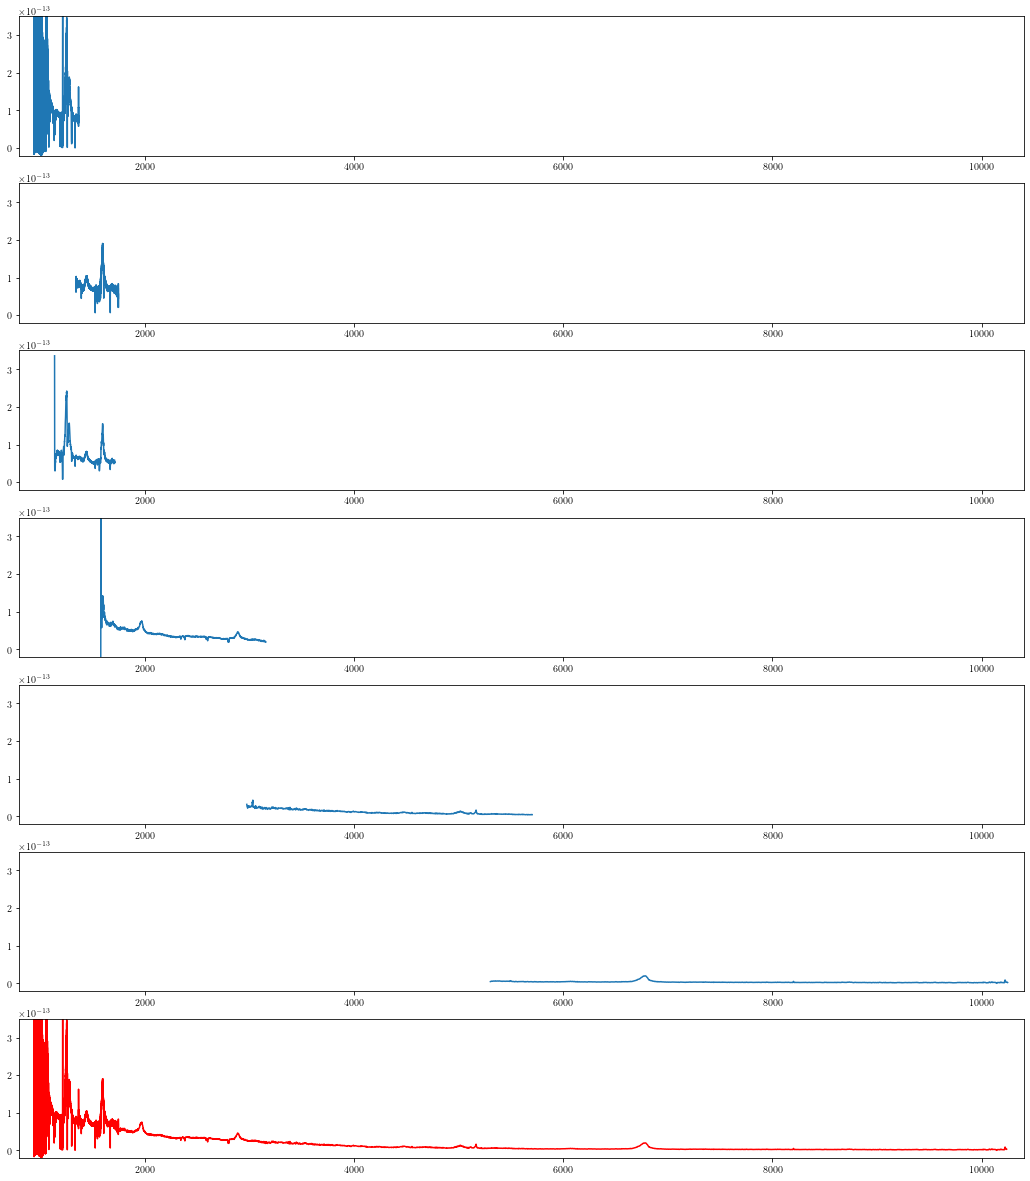

In [5]:
# 5

# Next, let's look at the per-grating co-adds on the same scale.

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

# COS G130M

table1 = fits.open(coadd_path+Mrk817_COS_G130M_const_file)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

hdul_1 = fits.open(coadd_path+Mrk817_COS_G130M_const_file)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
#print('These are the constituent files for Mrk 817 COS G130M: ',coadd_files)

# COS G160M

table2 = fits.open(coadd_path+Mrk817_COS_G160M_const_file)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

hdul_2 = fits.open(coadd_path+Mrk817_COS_G160M_const_file)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
#print('These are the constituent files for Mrk 817 COS G160M: ',coadd_files)

# STIS G140L

table3 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G140L: ',coadd_files)

# STIS G230L

table4 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

hdul_4 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file)
x1d_data4 = hdul_4[1].data
x1d_head4 = hdul_4[0].data

x1d_flux4 = x1d_data4['FLUX']
x1d_wave4 = x1d_data4['WAVELENGTH']
x1d_err4 = x1d_data4['ERROR']

coadd_prov = hdul_4[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G230L: ',coadd_files)

# STIS G430L

table5 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

hdul_5 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file)
x1d_data5 = hdul_5[1].data
x1d_head5 = hdul_5[0].data

x1d_flux5 = x1d_data5['FLUX']
x1d_wave5 = x1d_data5['WAVELENGTH']
x1d_err5 = x1d_data5['ERROR']

coadd_prov = hdul_5[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G430L: ',coadd_files)

# STIS G750L

table6 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

hdul_6 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file)
x1d_data6 = hdul_6[1].data
x1d_head6 = hdul_6[0].data

x1d_flux6 = x1d_data6['FLUX']
x1d_wave6 = x1d_data6['WAVELENGTH']
x1d_err6 = x1d_data6['ERROR']

coadd_prov = hdul_6[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G750L: ',coadd_files)

# Overall co-added spectrum

table0 = fits.open(coadd_path+Mrk817_coadd_file)[1].data
for row in table0:
    wave0 = row['wavelength']
    flux0 = row['flux']
    ax7.plot(wave0,flux0, color='red')

# Set appropriate scales.

ax1.set_xlim(800, 10400)
ax1.set_ylim(-0.2e-13, 3.5e-13)

ax2.set_xlim(800, 10400)
ax2.set_ylim(-0.2e-13, 3.5e-13)

ax3.set_xlim(800, 10400)
ax3.set_ylim(-0.2e-13, 3.5e-13)

ax4.set_xlim(800, 10400)
ax4.set_ylim(-0.2e-13, 3.5e-13)

ax5.set_xlim(800, 10400)
ax5.set_ylim(-0.2e-13, 3.5e-13)

ax6.set_xlim(800, 10400)
ax6.set_ylim(-0.2e-13, 3.5e-13)

ax7.set_xlim(800, 10400)
ax7.set_ylim(-0.2e-13, 3.5e-13)

#plt.savefig('PID16196_Mrk817_grating_coadds.pdf')


In [6]:
# 6

# As we learned from the last cell, each of the STIS co-added spectra
# is made up of only one (G140L), three (G230L), 
# or twelve (G430L, G750L) base-level constituents.
# ^ (previous co-add runs had only four base-level
#    constituents for each of G430L and G750L)
#
# G140L: 'oede4f080_x1d.fits'
#
# G230L: 'oedea5080_x1d.fits' 'oedea6080_x1d.fits' 'oedean080_x1d.fits'
#
# G430L: 'oede4f050_sx1.fits' 'oede4f060_sx1.fits' 'oede4f070_sx1.fits'
#        'oedea5050_sx1.fits' 'oedea5060_sx1.fits' 'oedea5070_sx1.fits'
#        'oedea6050_sx1.fits' 'oedea6060_sx1.fits' 'oedea6070_sx1.fits'
#        'oedean050_sx1.fits' 'oedean060_sx1.fits' 'oedean070_sx1.fits'
#
# G750L: 'oede4f020_sx1.fits' 'oede4f030_sx1.fits' 'oede4f040_sx1.fits'
#        'oedea5020_sx1.fits' 'oedea5030_sx1.fits' 'oedea5040_sx1.fits'
#        'oedea6020_sx1.fits' 'oedea6030_sx1.fits' 'oedea6040_sx1.fits'
#        'oedean020_sx1.fits' 'oedean030_sx1.fits' 'oedean040_sx1.fits'
#
# By examining the '/products/' directory for PID 16196,
# we can see how many co-adds there are per-grating.
#
# For G140L, there are three:
#
# hst_16196_stis_mrk-817_g140l_oede3o_cspec.fits
# hst_16196_stis_mrk-817_g140l_oede4b_cspec.fits
# hst_16196_stis_mrk-817_g140l_oede4f_cspec.fits*
#
# For G230L, there are six:
#
# hst_16196_stis_mrk-817_g230l_oede3o_cspec.fits
# hst_16196_stis_mrk-817_g230l_oede4b_cspec.fits
# hst_16196_stis_mrk-817_g230l_oede4f_cspec.fits
# hst_16196_stis_mrk-817_g230l_oedea5_cspec.fits*
# hst_16196_stis_mrk-817_g230l_oedea6_cspec.fits*
# hst_16196_stis_mrk-817_g230l_oedean_cspec.fits*
#
# For G430L, there are six:
#
# hst_16196_stis_mrk-817_g430l_oede3o_cspec.fits
# hst_16196_stis_mrk-817_g430l_oede4b_cspec.fits
# hst_16196_stis_mrk-817_g430l_oede4f_cspec.fits*
# hst_16196_stis_mrk-817_g430l_oedea5_cspec.fits*
# hst_16196_stis_mrk-817_g430l_oedea6_cspec.fits*
# hst_16196_stis_mrk-817_g430l_oedean_cspec.fits*
#
# For G750L, there are six:
#
# hst_16196_stis_mrk-817_g750l_oede3o_cspec.fits
# hst_16196_stis_mrk-817_g750l_oede4b_cspec.fits
# hst_16196_stis_mrk-817_g750l_oede4f_cspec.fits*
# hst_16196_stis_mrk-817_g750l_oedea5_cspec.fits*
# hst_16196_stis_mrk-817_g750l_oedea6_cspec.fits*
# hst_16196_stis_mrk-817_g750l_oedean_cspec.fits*
#
# The discrepancies between the number of co-adds there are
# and the listed number of base-level constituents per co-add
# suggests that some of the constituents are rejected
# prior to being included in the co-adds, which we can test.
#
# First, identify each of the constituent files:

Mrk817_STIS_G140L_const_file1 = 'hst_16196_stis_mrk-817_sg140l_oede3o_cspec.fits'
Mrk817_STIS_G140L_const_file2 = 'hst_16196_stis_mrk-817_sg140l_oede4b_cspec.fits'
Mrk817_STIS_G140L_const_file3 = 'hst_16196_stis_mrk-817_sg140l_oede4f_cspec.fits'

Mrk817_STIS_G230L_const_file1 = 'hst_16196_stis_mrk-817_sg230l_oede3o_cspec.fits'
Mrk817_STIS_G230L_const_file2 = 'hst_16196_stis_mrk-817_sg230l_oede4b_cspec.fits'
Mrk817_STIS_G230L_const_file3 = 'hst_16196_stis_mrk-817_sg230l_oede4f_cspec.fits'
Mrk817_STIS_G230L_const_file4 = 'hst_16196_stis_mrk-817_sg230l_oedea5_cspec.fits'
Mrk817_STIS_G230L_const_file5 = 'hst_16196_stis_mrk-817_sg230l_oedea6_cspec.fits'
Mrk817_STIS_G230L_const_file6 = 'hst_16196_stis_mrk-817_sg230l_oedean_cspec.fits'

Mrk817_STIS_G430L_const_file1 = 'hst_16196_stis_mrk-817_g430l_oede3o_cspec.fits'
Mrk817_STIS_G430L_const_file2 = 'hst_16196_stis_mrk-817_g430l_oede4b_cspec.fits'
Mrk817_STIS_G430L_const_file3 = 'hst_16196_stis_mrk-817_g430l_oede4f_cspec.fits'
Mrk817_STIS_G430L_const_file4 = 'hst_16196_stis_mrk-817_g430l_oedea5_cspec.fits'
Mrk817_STIS_G430L_const_file5 = 'hst_16196_stis_mrk-817_g430l_oedea6_cspec.fits'
Mrk817_STIS_G430L_const_file6 = 'hst_16196_stis_mrk-817_g430l_oedean_cspec.fits'

Mrk817_STIS_G750L_const_file1 = 'hst_16196_stis_mrk-817_g750l_oede3o_cspec.fits'
Mrk817_STIS_G750L_const_file2 = 'hst_16196_stis_mrk-817_g750l_oede4b_cspec.fits'
Mrk817_STIS_G750L_const_file3 = 'hst_16196_stis_mrk-817_g750l_oede4f_cspec.fits'
Mrk817_STIS_G750L_const_file4 = 'hst_16196_stis_mrk-817_g750l_oedea5_cspec.fits'
Mrk817_STIS_G750L_const_file5 = 'hst_16196_stis_mrk-817_g750l_oedea6_cspec.fits'
Mrk817_STIS_G750L_const_file6 = 'hst_16196_stis_mrk-817_g750l_oedean_cspec.fits'

# Then figure out what the base-level constituents of these are:

# STIS G140L

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file1)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G140L_1: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file2)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G140L_2: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G140L_3: ',coadd_files)
print('')

# STIS G230L

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file1)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G230L_1: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file2)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G230L_2: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G230L_3: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file4)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G230L_4: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file5)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G230L_5: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file6)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G230L_6: ',coadd_files)
print('')

# STIS G430L

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file1)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G430L_1: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file2)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G430L_2: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G430L_3: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file4)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G430L_4: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file5)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G430L_5: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file6)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G430L_6: ',coadd_files)
print('')

# STIS G750L

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file1)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G750L_1: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file2)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G750L_2: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G750L_3: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file4)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G750L_4: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file5)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G750L_5: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file6)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS G750L_6: ',coadd_files)


These are the constituent files for Mrk 817 STIS G140L_1:  ['oede3o080_x1d.fits']
These are the constituent files for Mrk 817 STIS G140L_2:  ['oede4b080_x1d.fits']
These are the constituent files for Mrk 817 STIS G140L_3:  ['oede4f080_x1d.fits']

These are the constituent files for Mrk 817 STIS G230L_1:  ['oede3o090_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_2:  ['oede4b090_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_3:  ['oede4f090_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_4:  ['oedea5080_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_5:  ['oedea6080_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_6:  ['oedean080_x1d.fits']

These are the constituent files for Mrk 817 STIS G430L_1:  ['oede3o050_sx1.fits' 'oede3o060_sx1.fits' 'oede3o070_sx1.fits']
These are the constituent files for Mrk 817 STIS G430L_2:  ['oede4b050_sx1.fits' 'oede4b060_sx1.fits' 'oede4b070_sx1.fits']
These are th

In [7]:
# 7

# Let's look at the base-level STIS constituent spectra.

#base_path = '/grp/hst/cos2/hsla/archive_2023-07-24/16196/'
#base_path = '/grp/hst/cos2/hsla/archive_2023_Aug_07/16196/'
#base_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-08-28/16196/'
base_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-09-14/16196/'

'''
These are the constituent files for Mrk 817 STIS G140L_1:  ['oede3o080_x1d.fits']
These are the constituent files for Mrk 817 STIS G140L_2:  ['oede4b080_x1d.fits']
These are the constituent files for Mrk 817 STIS G140L_3:  ['oede4f080_x1d.fits']

These are the constituent files for Mrk 817 STIS G230L_1:  ['oede3o090_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_2:  ['oede4b090_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_3:  ['oede4f090_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_4:  ['oedea5080_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_5:  ['oedea6080_x1d.fits']
These are the constituent files for Mrk 817 STIS G230L_6:  ['oedean080_x1d.fits']

These are the constituent files for Mrk 817 STIS G430L_1:  ['oede3o050_sx1.fits'
                                                            'oede3o060_sx1.fits'
                                                            'oede3o070_sx1.fits']
These are the constituent files for Mrk 817 STIS G430L_2:  ['oede4b050_sx1.fits'
                                                            'oede4b060_sx1.fits'
                                                            'oede4b070_sx1.fits']
These are the constituent files for Mrk 817 STIS G430L_3:  ['oede4f050_sx1.fits'
                                                            'oede4f060_sx1.fits'
                                                            'oede4f070_sx1.fits']
These are the constituent files for Mrk 817 STIS G430L_4:  ['oedea5050_sx1.fits'
                                                            'oedea5060_sx1.fits'
                                                            'oedea5070_sx1.fits']
These are the constituent files for Mrk 817 STIS G430L_5:  ['oedea6050_sx1.fits'
                                                            'oedea6060_sx1.fits'
                                                            'oedea6070_sx1.fits']
These are the constituent files for Mrk 817 STIS G430L_6:  ['oedean050_sx1.fits'
                                                            'oedean060_sx1.fits'
                                                            'oedean070_sx1.fits']

These are the constituent files for Mrk 817 STIS G750L_1:  ['oede3o020_sx1.fits'
                                                            'oede3o030_sx1.fits'
                                                            'oede3o040_sx1.fits']
These are the constituent files for Mrk 817 STIS G750L_2:  ['oede4b020_sx1.fits'
                                                            'oede4b030_sx1.fits'
                                                            'oede4b040_sx1.fits']
These are the constituent files for Mrk 817 STIS G750L_3:  ['oede4f020_sx1.fits'
                                                            'oede4f030_sx1.fits'
                                                            'oede4f040_sx1.fits']
These are the constituent files for Mrk 817 STIS G750L_4:  ['oedea5020_sx1.fits'
                                                            'oedea5030_sx1.fits'
                                                            'oedea5040_sx1.fits']
These are the constituent files for Mrk 817 STIS G750L_5:  ['oedea6020_sx1.fits'
                                                            'oedea6030_sx1.fits'
                                                            'oedea6040_sx1.fits']
These are the constituent files for Mrk 817 STIS G750L_6:  ['oedean020_sx1.fits'
                                                            'oedean030_sx1.fits'
                                                            'oedean040_sx1.fits']
'''

# STIS G140L

Mrk817_STIS_G140L_base_file1 = 'oede3o080_x1d.fits'
Mrk817_STIS_G140L_base_file2 = 'oede4b080_x1d.fits'
Mrk817_STIS_G140L_base_file3 = 'oede4f080_x1d.fits'

# STIS G230L

Mrk817_STIS_G230L_base_file1 = 'oede3o090_x1d.fits'
Mrk817_STIS_G230L_base_file2 = 'oede4b090_x1d.fits'
Mrk817_STIS_G230L_base_file3 = 'oede4f090_x1d.fits'
Mrk817_STIS_G230L_base_file4 = 'oedea5080_x1d.fits'
Mrk817_STIS_G230L_base_file5 = 'oedea6080_x1d.fits'
Mrk817_STIS_G230L_base_file6 = 'oedean080_x1d.fits'

# STIS G430L

Mrk817_STIS_G430L_base_file1a = 'oede3o050_sx1.fits'
Mrk817_STIS_G430L_base_file2a = 'oede4b050_sx1.fits'
Mrk817_STIS_G430L_base_file3a = 'oede4f050_sx1.fits'
Mrk817_STIS_G430L_base_file4a = 'oedea5050_sx1.fits'
Mrk817_STIS_G430L_base_file5a = 'oedea6050_sx1.fits'
Mrk817_STIS_G430L_base_file6a = 'oedean050_sx1.fits'

Mrk817_STIS_G430L_base_file1b = 'oede3o060_sx1.fits'
Mrk817_STIS_G430L_base_file2b = 'oede4b060_sx1.fits'
Mrk817_STIS_G430L_base_file3b = 'oede4f060_sx1.fits'
Mrk817_STIS_G430L_base_file4b = 'oedea5060_sx1.fits'
Mrk817_STIS_G430L_base_file5b = 'oedea6060_sx1.fits'
Mrk817_STIS_G430L_base_file6b = 'oedean060_sx1.fits'

Mrk817_STIS_G430L_base_file1c = 'oede3o070_sx1.fits'
Mrk817_STIS_G430L_base_file2c = 'oede4b070_sx1.fits'
Mrk817_STIS_G430L_base_file3c = 'oede4f070_sx1.fits'
Mrk817_STIS_G430L_base_file4c = 'oedea5070_sx1.fits'
Mrk817_STIS_G430L_base_file5c = 'oedea6070_sx1.fits'
Mrk817_STIS_G430L_base_file6c = 'oedean070_sx1.fits'

# STIS G750L

Mrk817_STIS_G750L_base_file1a = 'oede3o020_sx1.fits'
Mrk817_STIS_G750L_base_file2a = 'oede4b020_sx1.fits'
Mrk817_STIS_G750L_base_file3a = 'oede4f020_sx1.fits'
Mrk817_STIS_G750L_base_file4a = 'oedea5020_sx1.fits'
Mrk817_STIS_G750L_base_file5a = 'oedea6020_sx1.fits'
Mrk817_STIS_G750L_base_file6a = 'oedean020_sx1.fits'

Mrk817_STIS_G750L_base_file1b = 'oede3o030_sx1.fits'
Mrk817_STIS_G750L_base_file2b = 'oede4b030_sx1.fits'
Mrk817_STIS_G750L_base_file3b = 'oede4f030_sx1.fits'
Mrk817_STIS_G750L_base_file4b = 'oedea5030_sx1.fits'
Mrk817_STIS_G750L_base_file5b = 'oedea6030_sx1.fits'
Mrk817_STIS_G750L_base_file6b = 'oedean030_sx1.fits'

Mrk817_STIS_G750L_base_file1c = 'oede3o040_sx1.fits'
Mrk817_STIS_G750L_base_file2c = 'oede4b040_sx1.fits'
Mrk817_STIS_G750L_base_file3c = 'oede4f040_sx1.fits'
Mrk817_STIS_G750L_base_file4c = 'oedea5040_sx1.fits'
Mrk817_STIS_G750L_base_file5c = 'oedea6040_sx1.fits'
Mrk817_STIS_G750L_base_file6c = 'oedean040_sx1.fits'


(-1e-14, 3e-13)

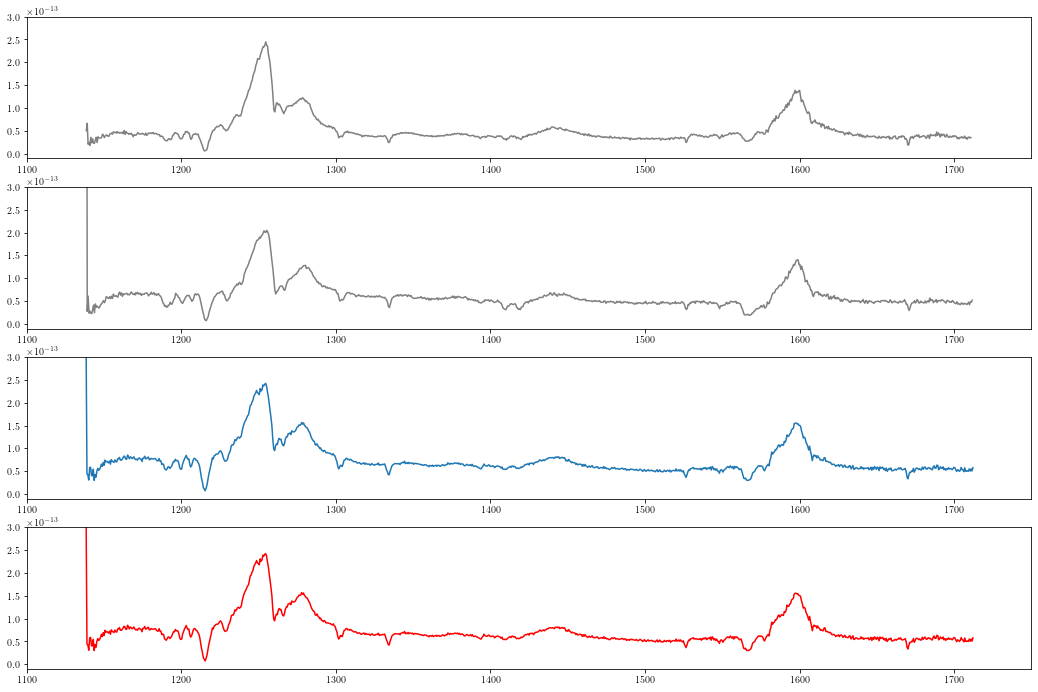

In [8]:
# 8

# What we're seeing is that each Visit-level co-add of STIS spectra
# is made up of one base-level constituent,
# but the per-grating co-added STIS spectra are only made up of
# a subset of these Visit-level co-adds,
# such that the overall Program-level co-add does not utilize
# all of the Visit-level co-added spectra.
#
# Let's plot them all (per-grating) and see what they look like,
# starting with G140L:

# STIS G140L

plt.figure(figsize=(18,12))

ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

table1 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-1.0e-14, 3.0e-13)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-1.0e-14, 3.0e-13)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-1.0e-14, 3.0e-13)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-1.0e-14, 3.0e-13)

#plt.savefig('PID16196_Mrk817_STIS_G140L_coadds.pdf')


(-1e-14, 3e-13)

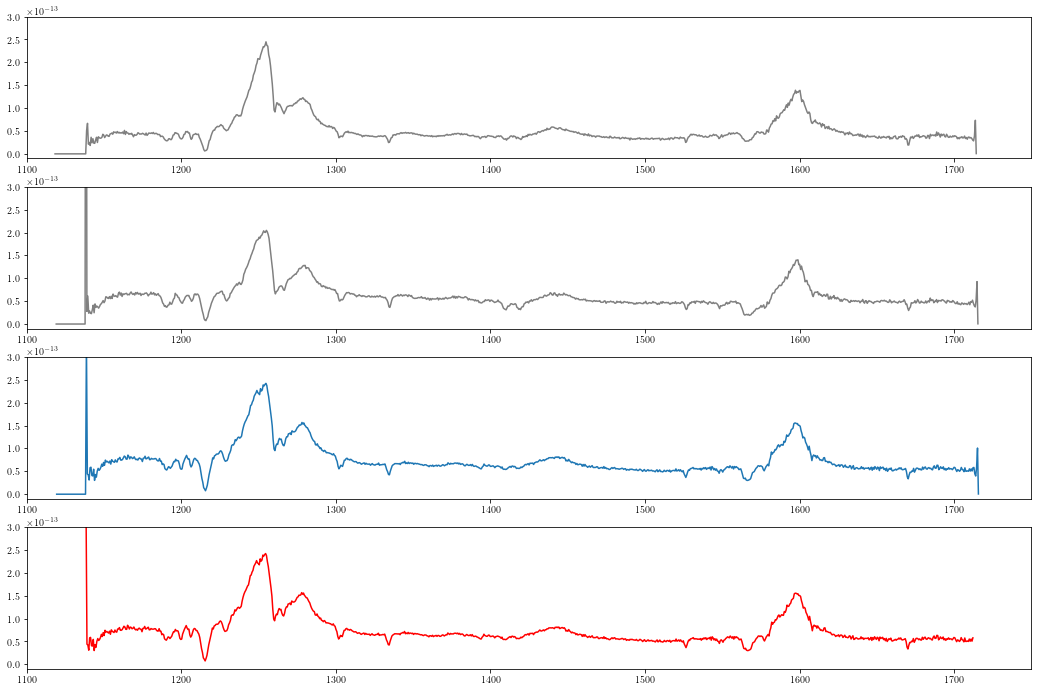

In [9]:
# 9

# Let's compare this with the STIS G140L base-level constituents.

# STIS G140L

plt.figure(figsize=(18,12))

ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

table1 = fits.open(base_path+Mrk817_STIS_G140L_base_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G140L_base_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G140L_base_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+Mrk817_STIS_G140L_const_file)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1100, 1750)
ax1.set_ylim(-1.0e-14, 3.0e-13)

ax2.set_xlim(1100, 1750)
ax2.set_ylim(-1.0e-14, 3.0e-13)

ax3.set_xlim(1100, 1750)
ax3.set_ylim(-1.0e-14, 3.0e-13)

ax4.set_xlim(1100, 1750)
ax4.set_ylim(-1.0e-14, 3.0e-13)

#plt.savefig('PID16196_Mrk817_STIS_G140L_constituents.pdf')


(-1e-14, 2e-13)

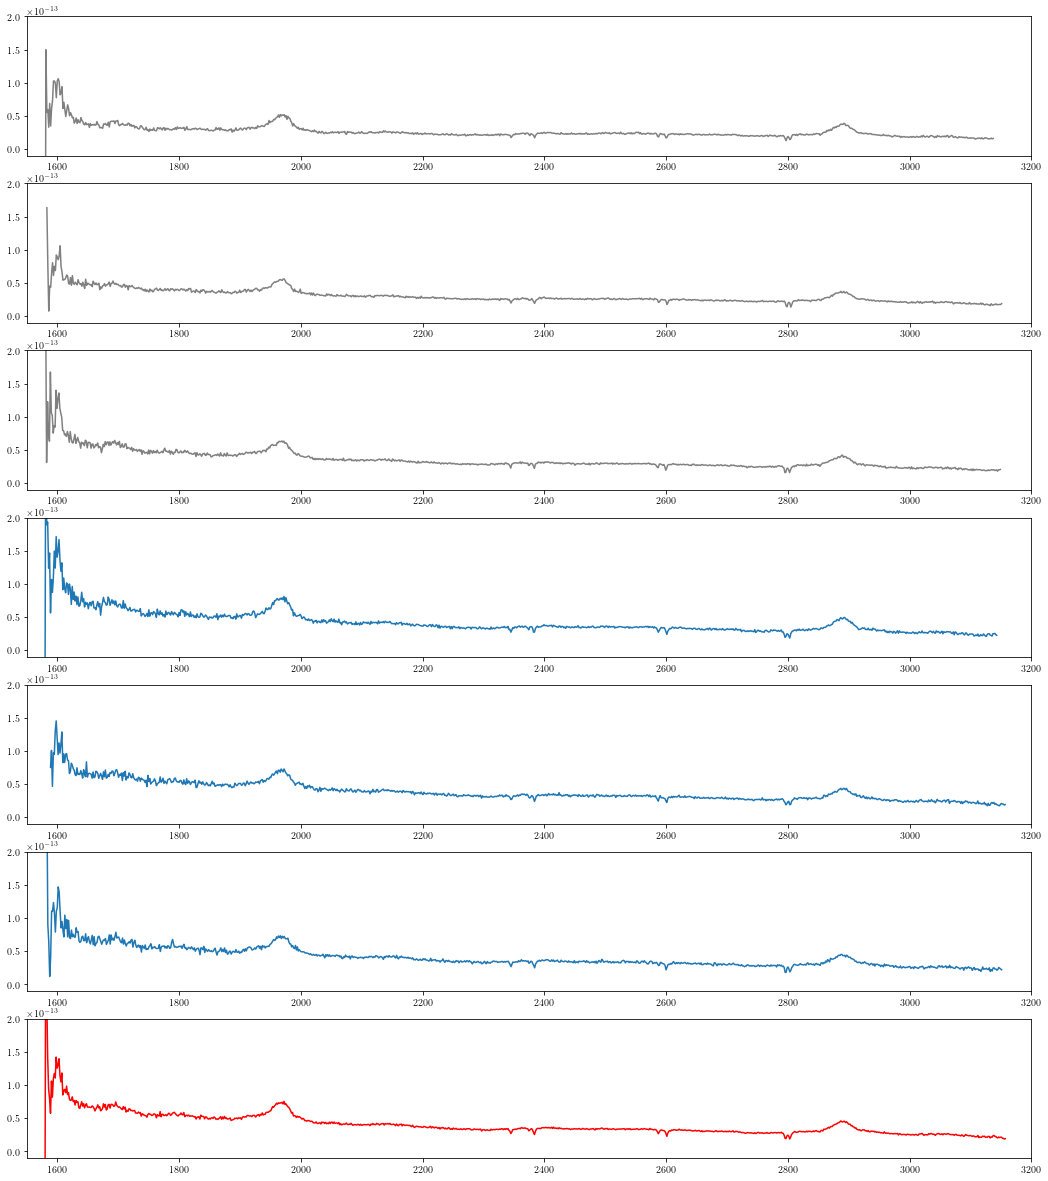

In [10]:
# 10

# Next, we'll examine the G230L co-adds:

# STIS G230L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3, color='gray')

table4 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file4)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file5)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file6)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1550, 3200)
ax1.set_ylim(-1.0e-14, 2.0e-13)

ax2.set_xlim(1550, 3200)
ax2.set_ylim(-1.0e-14, 2.0e-13)

ax3.set_xlim(1550, 3200)
ax3.set_ylim(-1.0e-14, 2.0e-13)

ax4.set_xlim(1550, 3200)
ax4.set_ylim(-1.0e-14, 2.0e-13)

ax5.set_xlim(1550, 3200)
ax5.set_ylim(-1.0e-14, 2.0e-13)

ax6.set_xlim(1550, 3200)
ax6.set_ylim(-1.0e-14, 2.0e-13)

ax7.set_xlim(1550, 3200)
ax7.set_ylim(-1.0e-14, 2.0e-13)

#plt.savefig('PID16196_Mrk817_STIS_G230L_coadds.pdf')


(-1e-14, 2e-13)

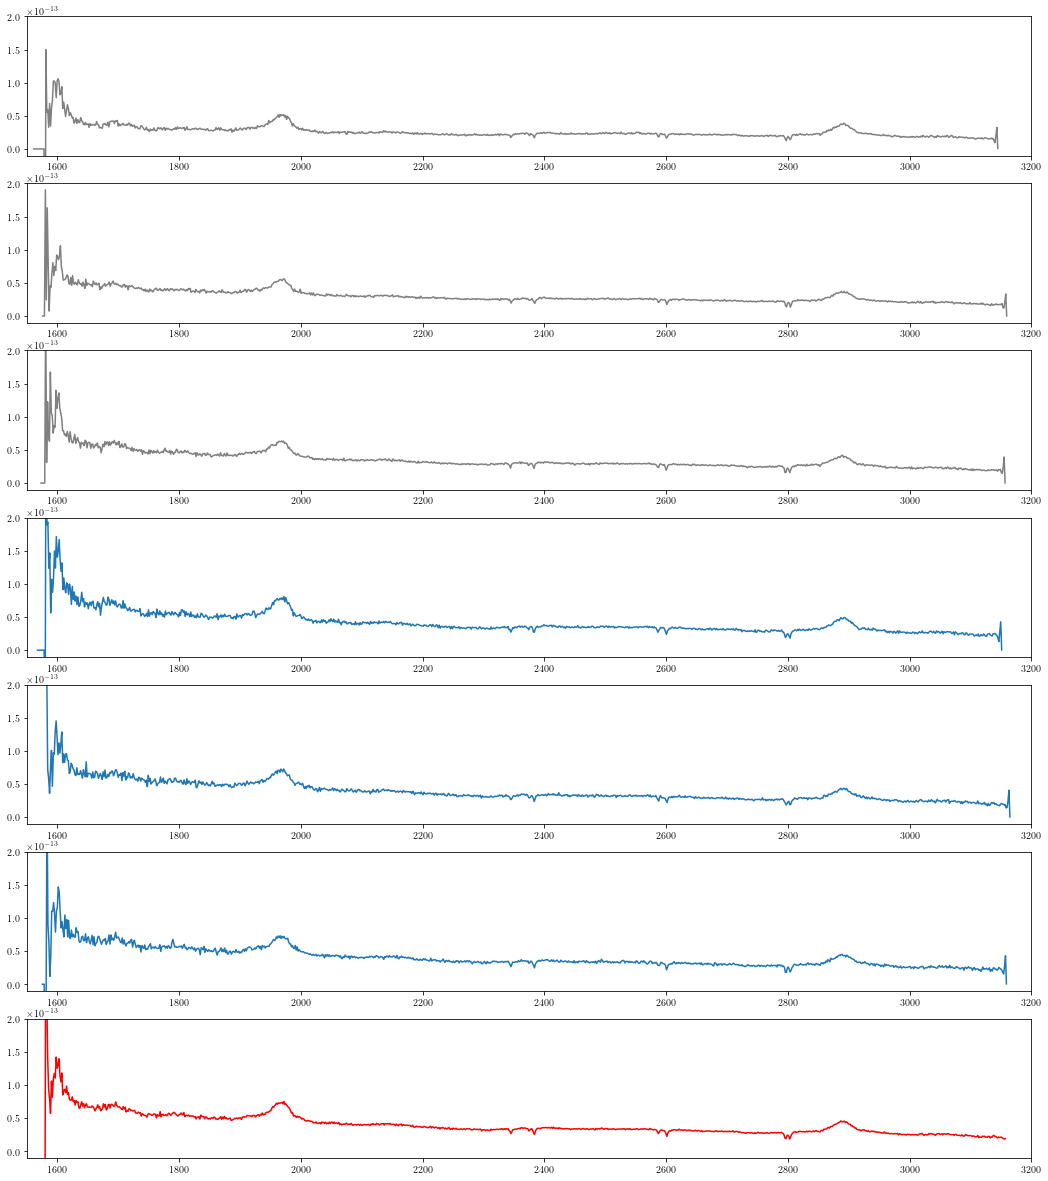

In [11]:
# 11

# Let's compare this with the STIS G230L base-level constituents.

# STIS G230L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+Mrk817_STIS_G230L_base_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G230L_base_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G230L_base_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3, color='gray')

table4 = fits.open(base_path+Mrk817_STIS_G230L_base_file4)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+Mrk817_STIS_G230L_base_file5)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+Mrk817_STIS_G230L_base_file6)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G230L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(1550, 3200)
ax1.set_ylim(-1.0e-14, 2.0e-13)

ax2.set_xlim(1550, 3200)
ax2.set_ylim(-1.0e-14, 2.0e-13)

ax3.set_xlim(1550, 3200)
ax3.set_ylim(-1.0e-14, 2.0e-13)

ax4.set_xlim(1550, 3200)
ax4.set_ylim(-1.0e-14, 2.0e-13)

ax5.set_xlim(1550, 3200)
ax5.set_ylim(-1.0e-14, 2.0e-13)

ax6.set_xlim(1550, 3200)
ax6.set_ylim(-1.0e-14, 2.0e-13)

ax7.set_xlim(1550, 3200)
ax7.set_ylim(-1.0e-14, 2.0e-13)

#plt.savefig('PID16196_Mrk817_STIS_G230L_constituents.pdf')


(-2e-15, 4.5e-14)

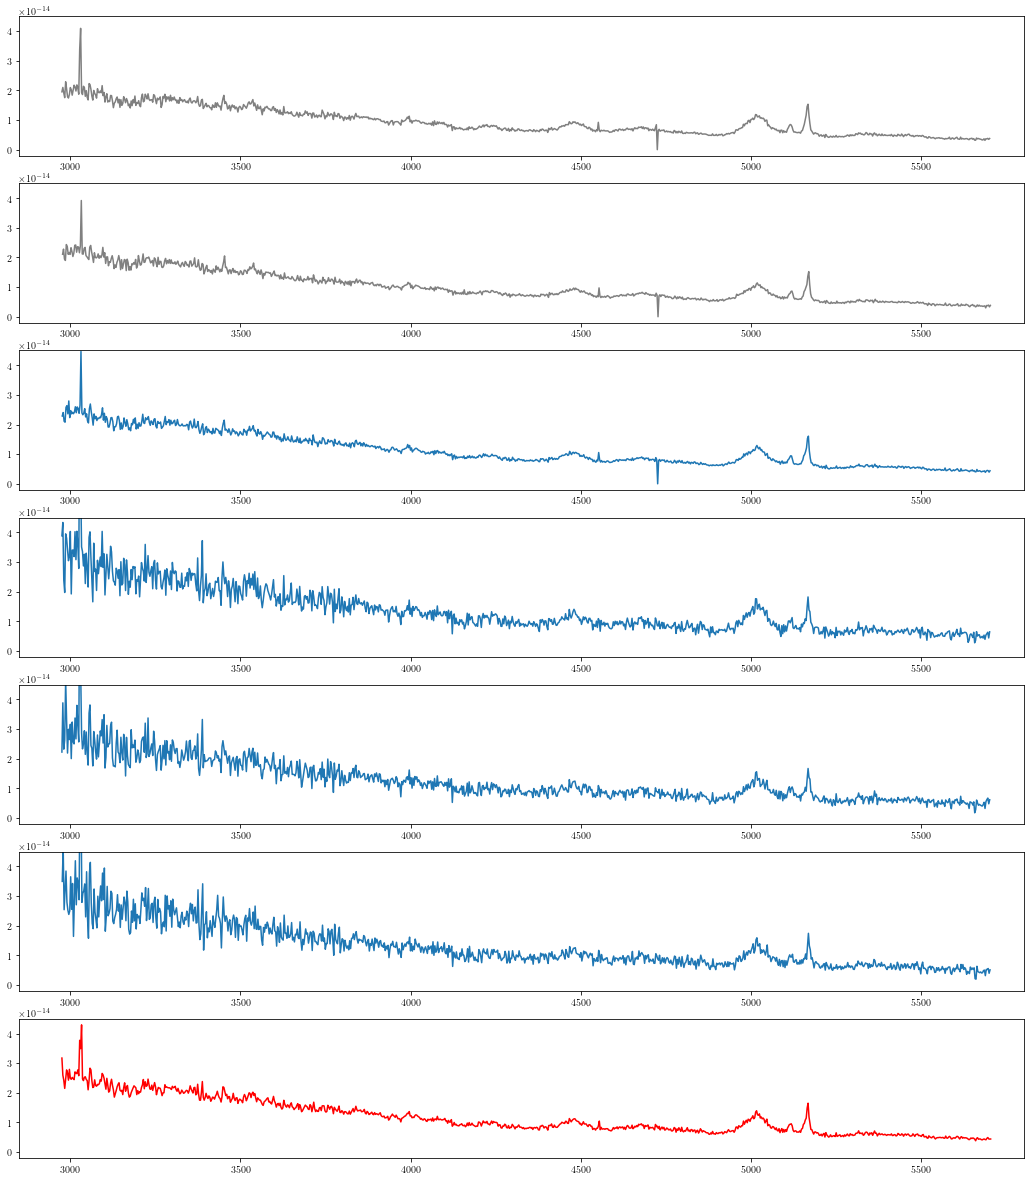

In [12]:
# 12

# Next, the STIS G430L co-adds:

# STIS G430L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file4)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file5)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file6)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(2850, 5800)
ax1.set_ylim(-0.2e-14, 4.5e-14)

ax2.set_xlim(2850, 5800)
ax2.set_ylim(-0.2e-14, 4.5e-14)

ax3.set_xlim(2850, 5800)
ax3.set_ylim(-0.2e-14, 4.5e-14)

ax4.set_xlim(2850, 5800)
ax4.set_ylim(-0.2e-14, 4.5e-14)

ax5.set_xlim(2850, 5800)
ax5.set_ylim(-0.2e-14, 4.5e-14)

ax6.set_xlim(2850, 5800)
ax6.set_ylim(-0.2e-14, 4.5e-14)

ax7.set_xlim(2850, 5800)
ax7.set_ylim(-0.2e-14, 4.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G430L_coadds.pdf')


(-2e-15, 4.5e-14)

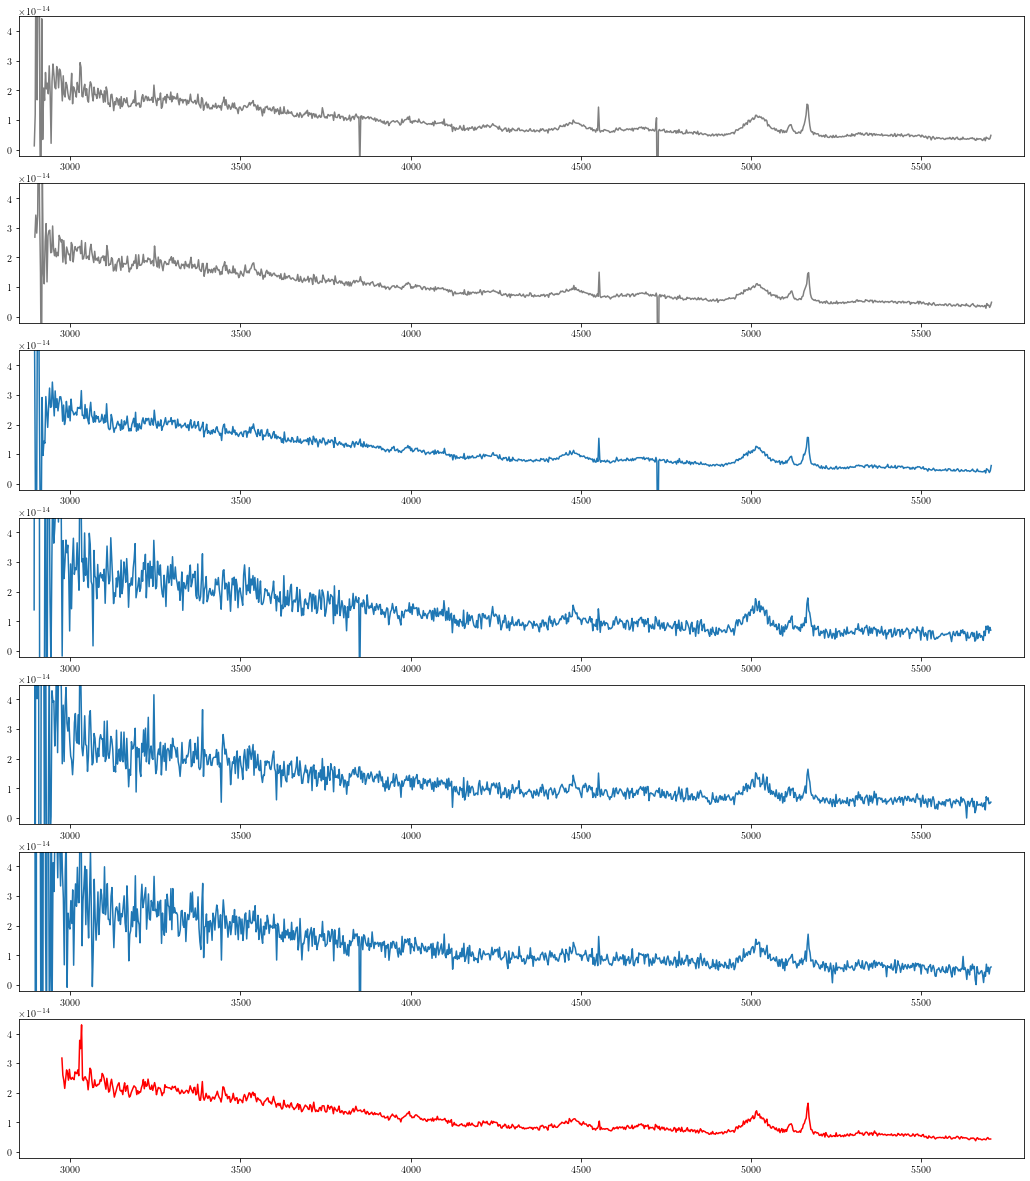

In [13]:
# 13

# Compare with the STIS G430L constituents:

# STIS G430L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+Mrk817_STIS_G430L_base_file1a)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G430L_base_file2a)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G430L_base_file3a)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(base_path+Mrk817_STIS_G430L_base_file4a)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+Mrk817_STIS_G430L_base_file5a)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+Mrk817_STIS_G430L_base_file6a)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(2850, 5800)
ax1.set_ylim(-0.2e-14, 4.5e-14)

ax2.set_xlim(2850, 5800)
ax2.set_ylim(-0.2e-14, 4.5e-14)

ax3.set_xlim(2850, 5800)
ax3.set_ylim(-0.2e-14, 4.5e-14)

ax4.set_xlim(2850, 5800)
ax4.set_ylim(-0.2e-14, 4.5e-14)

ax5.set_xlim(2850, 5800)
ax5.set_ylim(-0.2e-14, 4.5e-14)

ax6.set_xlim(2850, 5800)
ax6.set_ylim(-0.2e-14, 4.5e-14)

ax7.set_xlim(2850, 5800)
ax7.set_ylim(-0.2e-14, 4.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G430L_constituents.pdf')


(-2e-15, 4.5e-14)

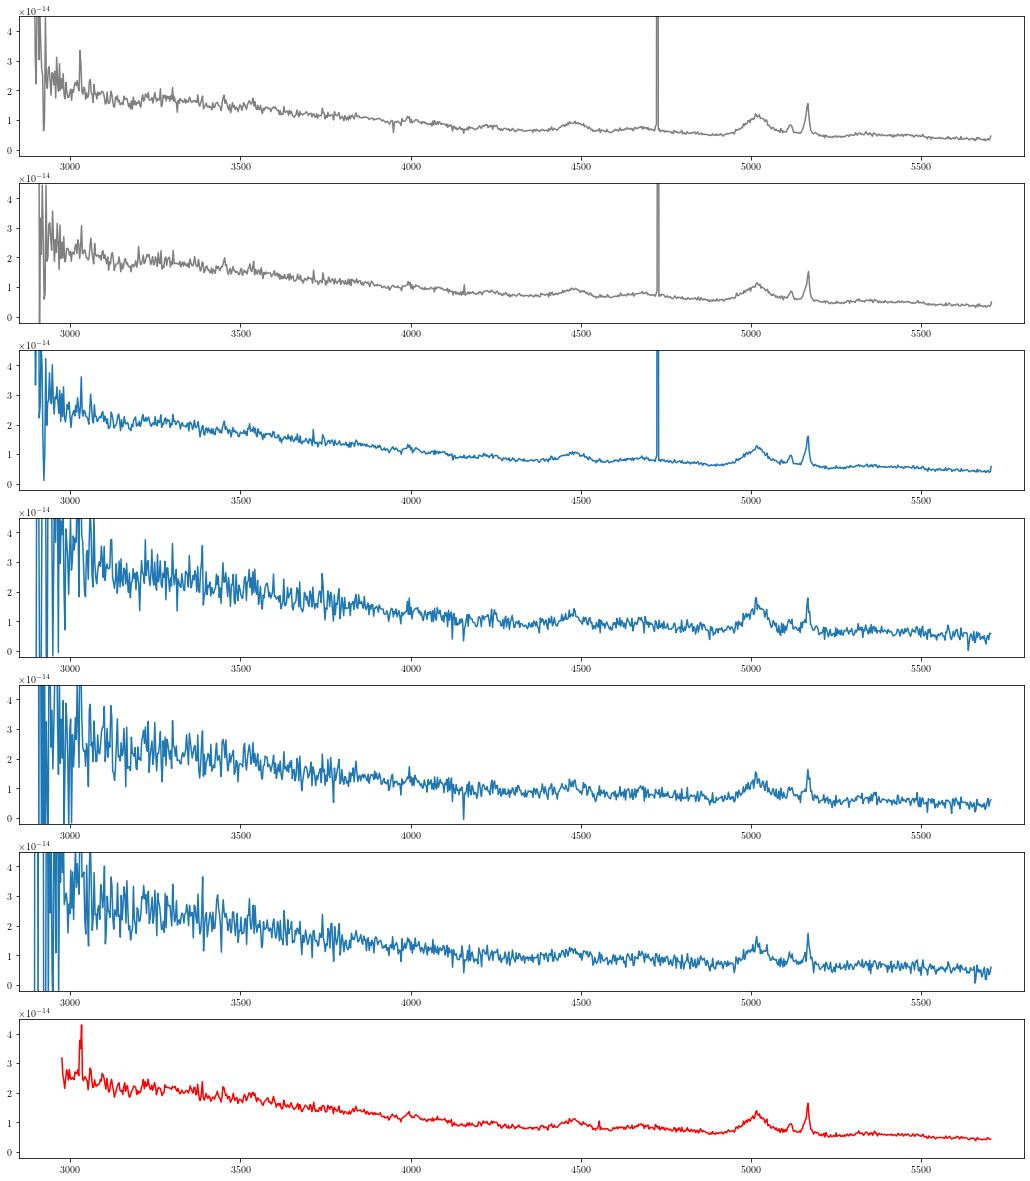

In [14]:
# 14

# Compare with the STIS G430L constituents:

# STIS G430L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+Mrk817_STIS_G430L_base_file1b)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G430L_base_file2b)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G430L_base_file3b)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(base_path+Mrk817_STIS_G430L_base_file4b)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+Mrk817_STIS_G430L_base_file5b)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+Mrk817_STIS_G430L_base_file6b)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(2850, 5800)
ax1.set_ylim(-0.2e-14, 4.5e-14)

ax2.set_xlim(2850, 5800)
ax2.set_ylim(-0.2e-14, 4.5e-14)

ax3.set_xlim(2850, 5800)
ax3.set_ylim(-0.2e-14, 4.5e-14)

ax4.set_xlim(2850, 5800)
ax4.set_ylim(-0.2e-14, 4.5e-14)

ax5.set_xlim(2850, 5800)
ax5.set_ylim(-0.2e-14, 4.5e-14)

ax6.set_xlim(2850, 5800)
ax6.set_ylim(-0.2e-14, 4.5e-14)

ax7.set_xlim(2850, 5800)
ax7.set_ylim(-0.2e-14, 4.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G430L_constituents.pdf')


(-2e-15, 4.5e-14)

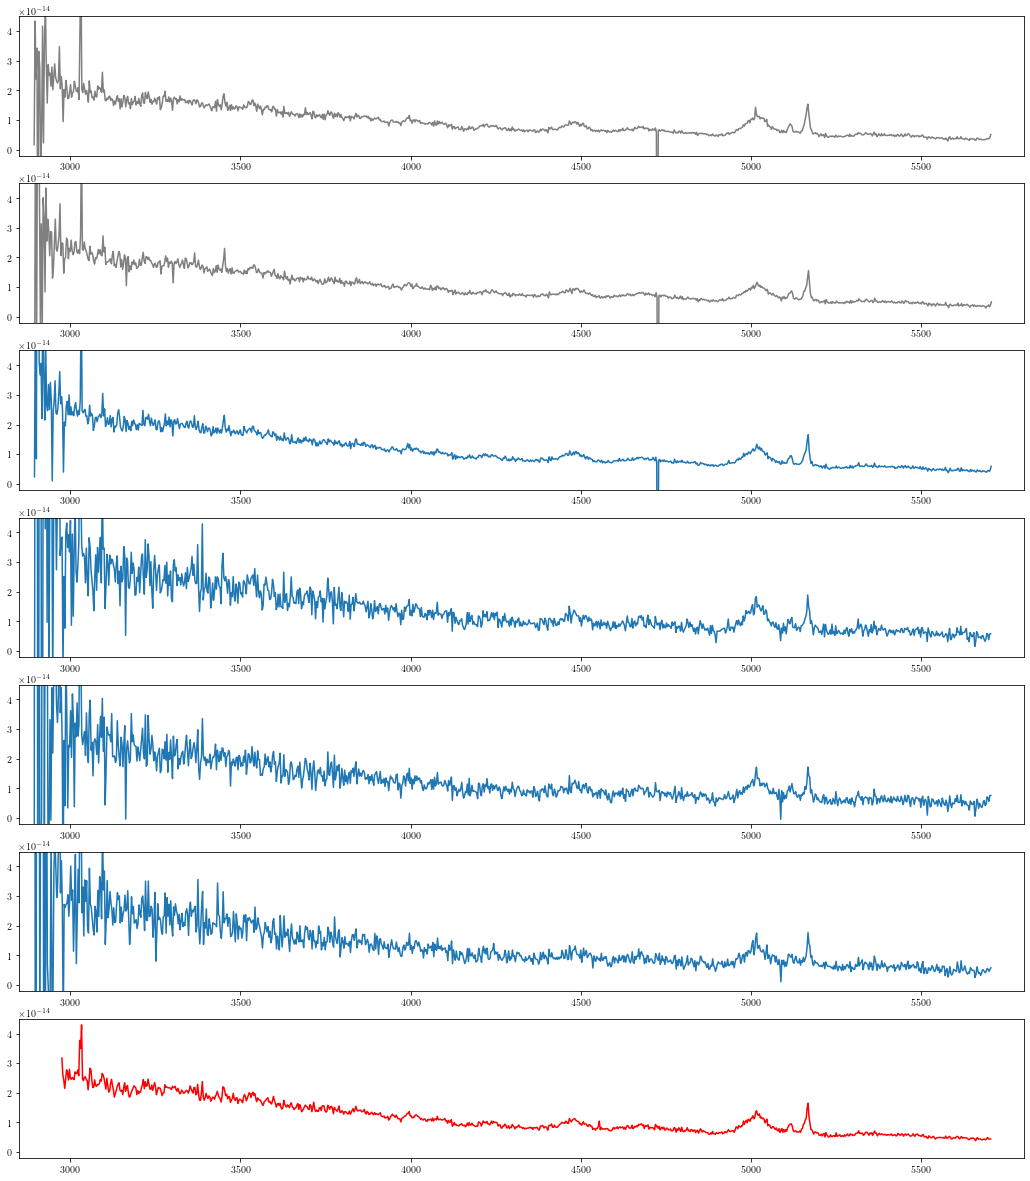

In [15]:
# 15

# Compare with the STIS G430L constituents:

# STIS G430L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+Mrk817_STIS_G430L_base_file1c)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G430L_base_file2c)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G430L_base_file3c)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(base_path+Mrk817_STIS_G430L_base_file4c)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+Mrk817_STIS_G430L_base_file5c)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+Mrk817_STIS_G430L_base_file6c)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G430L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(2850, 5800)
ax1.set_ylim(-0.2e-14, 4.5e-14)

ax2.set_xlim(2850, 5800)
ax2.set_ylim(-0.2e-14, 4.5e-14)

ax3.set_xlim(2850, 5800)
ax3.set_ylim(-0.2e-14, 4.5e-14)

ax4.set_xlim(2850, 5800)
ax4.set_ylim(-0.2e-14, 4.5e-14)

ax5.set_xlim(2850, 5800)
ax5.set_ylim(-0.2e-14, 4.5e-14)

ax6.set_xlim(2850, 5800)
ax6.set_ylim(-0.2e-14, 4.5e-14)

ax7.set_xlim(2850, 5800)
ax7.set_ylim(-0.2e-14, 4.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G430L_constituents.pdf')


(-2e-15, 2.5e-14)

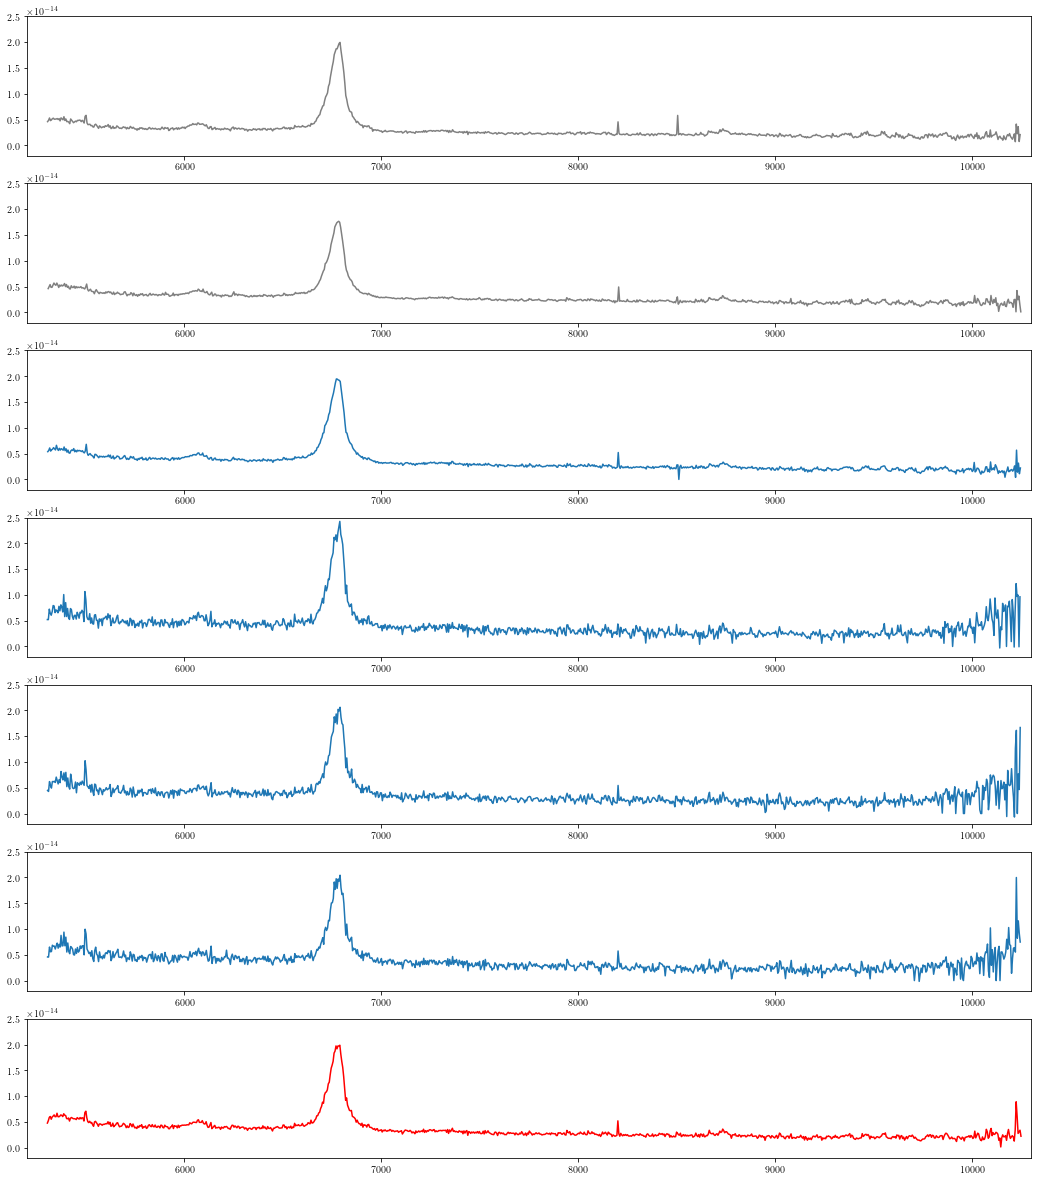

In [16]:
# 16

# Finally, the STIS G750L co-adds:

# STIS G750L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file3)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file4)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file5)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file6)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(5200, 10300)
ax1.set_ylim(-0.2e-14, 2.5e-14)

ax2.set_xlim(5200, 10300)
ax2.set_ylim(-0.2e-14, 2.5e-14)

ax3.set_xlim(5200, 10300)
ax3.set_ylim(-0.2e-14, 2.5e-14)

ax4.set_xlim(5200, 10300)
ax4.set_ylim(-0.2e-14, 2.5e-14)

ax5.set_xlim(5200, 10300)
ax5.set_ylim(-0.2e-14, 2.5e-14)

ax6.set_xlim(5200, 10300)
ax6.set_ylim(-0.2e-14, 2.5e-14)

ax7.set_xlim(5200, 10300)
ax7.set_ylim(-0.2e-14, 2.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G750L_coadds.pdf')


(-2e-15, 2.5e-14)

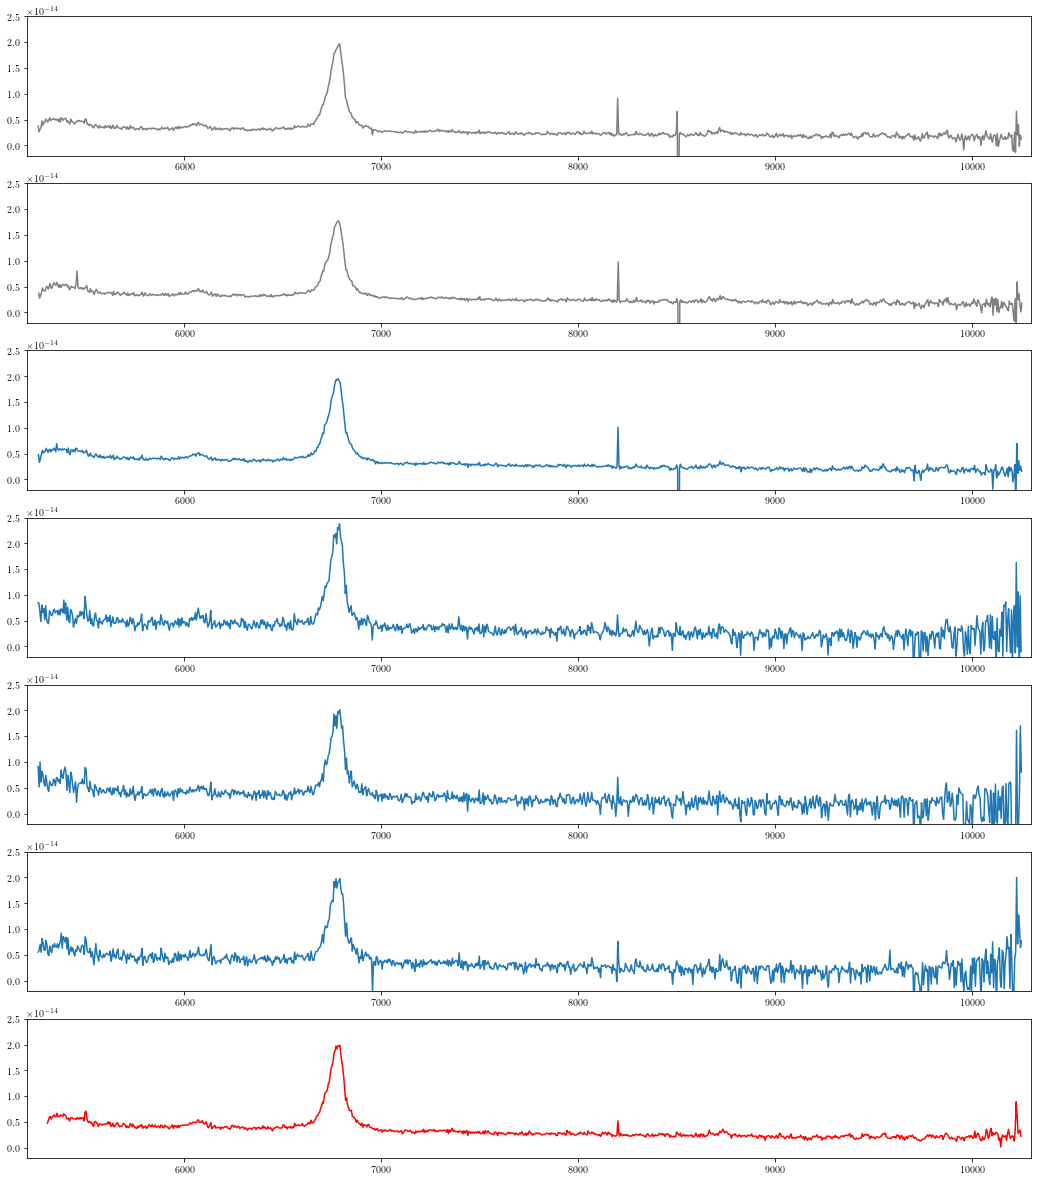

In [17]:
# 17

# And last, the STIS G750L constituents.

# STIS G750L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+Mrk817_STIS_G750L_base_file1a)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G750L_base_file2a)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G750L_base_file3a)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(base_path+Mrk817_STIS_G750L_base_file4a)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+Mrk817_STIS_G750L_base_file5a)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+Mrk817_STIS_G750L_base_file6a)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(5200, 10300)
ax1.set_ylim(-0.2e-14, 2.5e-14)

ax2.set_xlim(5200, 10300)
ax2.set_ylim(-0.2e-14, 2.5e-14)

ax3.set_xlim(5200, 10300)
ax3.set_ylim(-0.2e-14, 2.5e-14)

ax4.set_xlim(5200, 10300)
ax4.set_ylim(-0.2e-14, 2.5e-14)

ax5.set_xlim(5200, 10300)
ax5.set_ylim(-0.2e-14, 2.5e-14)

ax6.set_xlim(5200, 10300)
ax6.set_ylim(-0.2e-14, 2.5e-14)

ax7.set_xlim(5200, 10300)
ax7.set_ylim(-0.2e-14, 2.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G750L_constituents.pdf')


(-2e-15, 2.5e-14)

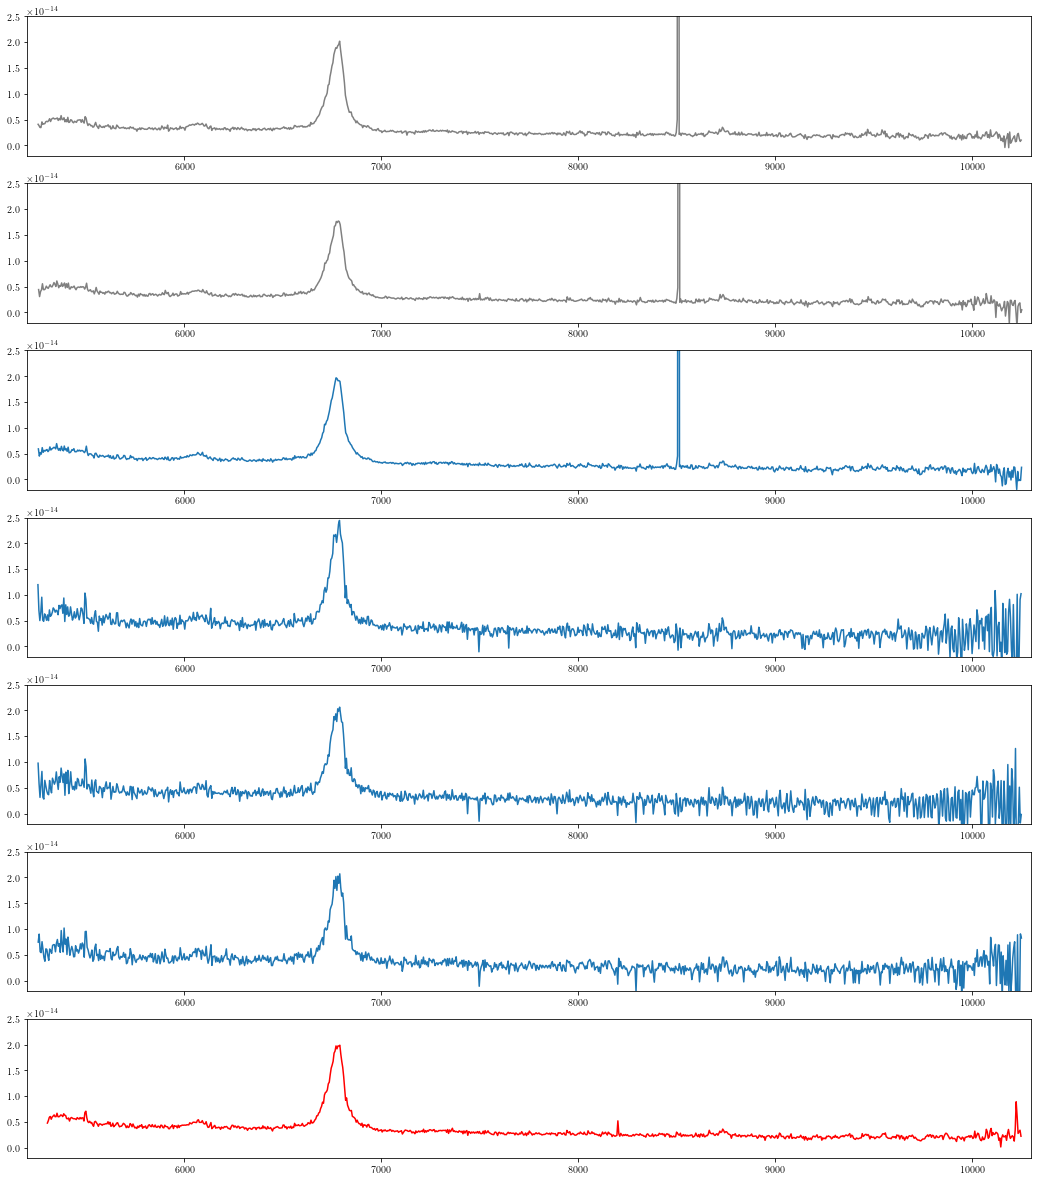

In [18]:
# 18

# And last, the STIS G750L constituents.

# STIS G750L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+Mrk817_STIS_G750L_base_file1b)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G750L_base_file2b)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G750L_base_file3b)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(base_path+Mrk817_STIS_G750L_base_file4b)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+Mrk817_STIS_G750L_base_file5b)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+Mrk817_STIS_G750L_base_file6b)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(5200, 10300)
ax1.set_ylim(-0.2e-14, 2.5e-14)

ax2.set_xlim(5200, 10300)
ax2.set_ylim(-0.2e-14, 2.5e-14)

ax3.set_xlim(5200, 10300)
ax3.set_ylim(-0.2e-14, 2.5e-14)

ax4.set_xlim(5200, 10300)
ax4.set_ylim(-0.2e-14, 2.5e-14)

ax5.set_xlim(5200, 10300)
ax5.set_ylim(-0.2e-14, 2.5e-14)

ax6.set_xlim(5200, 10300)
ax6.set_ylim(-0.2e-14, 2.5e-14)

ax7.set_xlim(5200, 10300)
ax7.set_ylim(-0.2e-14, 2.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G750L_constituents.pdf')


(-2e-15, 2.5e-14)

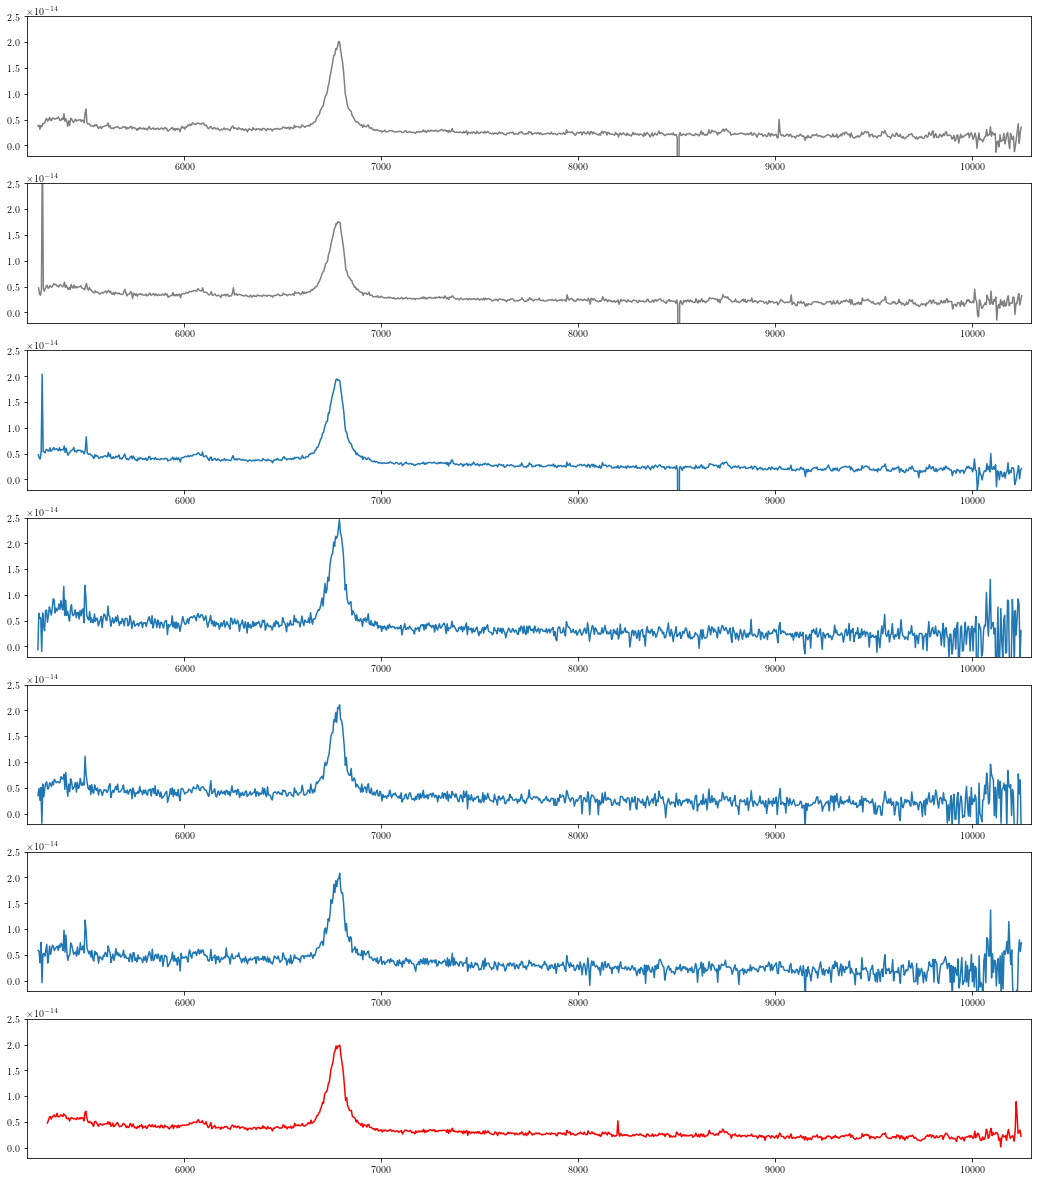

In [19]:
# 19

# And last, the STIS G750L constituents.

# STIS G750L

plt.figure(figsize=(18,21))

ax1 = plt.subplot(711)
ax2 = plt.subplot(712)
ax3 = plt.subplot(713)
ax4 = plt.subplot(714)
ax5 = plt.subplot(715)
ax6 = plt.subplot(716)
ax7 = plt.subplot(717)

table1 = fits.open(base_path+Mrk817_STIS_G750L_base_file1c)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1, color='gray')

table2 = fits.open(base_path+Mrk817_STIS_G750L_base_file2c)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2, color='gray')

table3 = fits.open(base_path+Mrk817_STIS_G750L_base_file3c)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(base_path+Mrk817_STIS_G750L_base_file4c)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+Mrk817_STIS_G750L_base_file5c)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+Mrk817_STIS_G750L_base_file6c)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(coadd_path+Mrk817_STIS_G750L_const_file)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7, color='red')
    
# Set appropriate scales.

ax1.set_xlim(5200, 10300)
ax1.set_ylim(-0.2e-14, 2.5e-14)

ax2.set_xlim(5200, 10300)
ax2.set_ylim(-0.2e-14, 2.5e-14)

ax3.set_xlim(5200, 10300)
ax3.set_ylim(-0.2e-14, 2.5e-14)

ax4.set_xlim(5200, 10300)
ax4.set_ylim(-0.2e-14, 2.5e-14)

ax5.set_xlim(5200, 10300)
ax5.set_ylim(-0.2e-14, 2.5e-14)

ax6.set_xlim(5200, 10300)
ax6.set_ylim(-0.2e-14, 2.5e-14)

ax7.set_xlim(5200, 10300)
ax7.set_ylim(-0.2e-14, 2.5e-14)

#plt.savefig('PID16196_Mrk817_STIS_G750L_constituents.pdf')


In [20]:
# 20

# What are the base-level constituent files which go into
# the STIS-exclusive overall co-add(s)?
#
# hst_16196_stis_mrk-817_g140l-g230l-g430l-g750l_oede3o_cspec.fits
# hst_16196_stis_mrk-817_g140l-g230l-g430l-g750l_oede4b_cspec.fits
# hst_16196_stis_mrk-817_g140l-g230l-g430l-g750l_oede4f_cspec.fits

Mrk817_STIS_allgrating_const_file1 = 'hst_16196_stis_mrk-817_sg140l-sg230l-g430l-g750l_oede3o_cspec.fits'
Mrk817_STIS_allgrating_const_file2 = 'hst_16196_stis_mrk-817_sg140l-sg230l-g430l-g750l_oede4b_cspec.fits'
Mrk817_STIS_allgrating_const_file3 = 'hst_16196_stis_mrk-817_sg140l-sg230l-g430l-g750l_oede4f_cspec.fits'

# Now that we've identified the all-grating constituents,
# let's see what base-level files make up each one.

hdul_3 = fits.open(coadd_path+Mrk817_STIS_allgrating_const_file1)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS all-grating_1: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_allgrating_const_file2)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS all-grating_2: ',coadd_files)

hdul_3 = fits.open(coadd_path+Mrk817_STIS_allgrating_const_file3)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for Mrk 817 STIS all-grating_3: ',coadd_files)
print('')


These are the constituent files for Mrk 817 STIS all-grating_1:  ['oede3o080_x1d.fits' 'oede3o090_x1d.fits' 'oede3o050_sx1.fits'
 'oede3o060_sx1.fits' 'oede3o070_sx1.fits' 'oede3o020_sx1.fits'
 'oede3o030_sx1.fits' 'oede3o040_sx1.fits']
These are the constituent files for Mrk 817 STIS all-grating_2:  ['oede4b080_x1d.fits' 'oede4b090_x1d.fits' 'oede4b050_sx1.fits'
 'oede4b060_sx1.fits' 'oede4b070_sx1.fits' 'oede4b020_sx1.fits'
 'oede4b030_sx1.fits' 'oede4b040_sx1.fits']
These are the constituent files for Mrk 817 STIS all-grating_3:  ['oede4f080_x1d.fits' 'oede4f090_x1d.fits' 'oede4f050_sx1.fits'
 'oede4f060_sx1.fits' 'oede4f070_sx1.fits' 'oede4f020_sx1.fits'
 'oede4f030_sx1.fits' 'oede4f040_sx1.fits']



In [21]:
# 21

# S/N

#SNR = x1d_flux3 / x1d_err3

#print('S/N =', SNR)
